# SNR Grid Calculations Tutorial

Update Summary

In load_inputs.py:

Added function for dynamic instrument contrast

Added off-axis mode imaging.

Added function to get planetary spectra

In noise_tools.py:

Fixed bugs with instrumental noise and sky noise (added exposure time), added coupling term for noise calculation throughput

In objects.py:

Added class on coronagraphs as well as planetary data

In plot.tools.py:

Added function for plotting signal and noise in on-axis mode

Added function to plot signal and noise , and SNR in off-axis mode

Added function to plot instrument contrast

Added a function to plot sky noise and instrumental noise.

All updates are bracketed by "####" and descriptions are written for each update

## MODHIS

In [1]:
# import some general packages
import sys,os
import matplotlib
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from matplotlib.colors import LogNorm
from datetime import date
from astropy import units as u

# make plot fonts big
font = {'size'   : 14}
matplotlib.rc('font', **font)

# Load path to package and load a few useful things
sys.path.append('/Users/huihaoz/specsim/utils/')
from objects import load_object
from load_inputs import fill_data
from functions import *
import plot_tools,obs_tools



## Loading Config File & Running an Observation

### Background
Key parameters are stored in the configuration file "hispec.cfg". The function "load_object" loads the contents of this configuration file into a storage object "so'. The objects.py function is a useful reference for seeing what is contained in so, but it has class attributes like 'stel' for stellar properties and 'track' for tracking camera properties. For example, the stellar temperature defined in the config file will be loaded and stored in "so.stel.teff".

The "fill_data" class takes the storage object and upon initiation, it fills the so object by running a bunch of things. As such, this process takes a little while - first it defines the wavelength grid (x) and yJHK filter bounds, then does the dirty work of loading, reinterpolating files, and calculating things in the following order:

**filter**
    (loads zeropoint and filter transmission curve for the band selected)

**stellar** 
    (loads the stellar spectrum based on the temperature chosen and scales it to the magnitude requested in the filter band set in the filter attribute of so)

**telluric**
    (loads the telluric spectrum and scales to the requested PWV and airmass)

**ao**
    (by default takes the magnitude of the star and uses input files to determine the expected WFE based on the AO mode selected which should match headers in the file. Or one can just set the params to some WFE)

**instrument**
    (loads the instrument transmission file if there is one, otherwise does HISPEC/MODHIS specific things and loads the base throughput and finds the coupling based on the WFE found previously assuming a specific file format)

**observe** 
    (takes all the loaded files to find the spectral flux at the instruments and degrades and resamples the spectrum according to the resolution and pixels provided. It also loads the background spectrum and noise to get the SNR per pixel and per resolution element)

**tracking** 
    (loads the tracking camera properties for the camera specified, loads the transmission file, interpolates, calculates the platescale, makes the tracking band transmission file, computs the PSF FWHM and the strehl, determines the sky and instrument background, computes the photons at the tracking camera, combines the noise, gives the SNR and expected centroid error
    
There are some other functions in the load_objects.py that can be used to reload a subset of things and are useful since there are a lot of orders of operations. These are still kinda confusing but I will demonstrate how I use them to cycle over a lot of parameters

## The Code - Running A Single Instance
Here is the code to load a config file and run it

In [2]:
configfile = '/Users/huihaoz/specsim/examples/modhis.cfg' # define our config file name and path

In [3]:
so    = load_object(configfile)     # Load the contents of the config file into the so "storage object"

In [4]:
cload = fill_data(so)               # Initiate the fill_data class which runs an observation and stores the results in so

------FILLING OBJECT--------
Planet Teff set to 700.0
Planet K band mag set to 19.0
Star Teff set to 2800.0
Star K band mag set to 14.0
HO WFE V mag is 20.288981656569298
Tip Tilt V mag is 20.288981656569298
AO mode: LGS_OFF
HO WFE is 213.0
tt dynamic is 2.55
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


Tracking FWHM=3.8487820712158713pix
Tracking photons: 135937.1085128926 e-
Tracking noise: 371.10655227311906 e-
dynamic instrument contrast ready
Texp per frame set to 900.0
Nframes set to 16
direct imaging ready


/Users/huihaoz/specsim/utils/noise_tools.py:252: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:256: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)


# Changing a parameter - Method 1
The following example shows how to change the temperature of the star and rerun using the same code. At a different temperature, the magnitude of the star in the band pertinent to defining the AO performance will be different and therefore the AO performance will be different

# Changing a parameter - Method 2
Some parameters or situations don't require re-running everything. For example, maybe you don't care about the tracking camera. Or if we only want to change something related to the tracking camera, we don't need to re-run the spectrograph. In this case we can use some of the extra functions defined in the fill_data class such as 'set_tracking_band_texp' or 'set_filter_band_mag'. Here is an example:

# Plotting the Spectrum, on-axis
There are several tools for plotting in plot_tools.py which we loaded earlier as plot_tools. Not all plot functions are currently working well and a lot require certain data paths to be fixed. 

Here is an example how to use some of the key ones that should work! For example, how to plot the SNR spectrum, the base throughput, the background noise,the signal spectrum, etc. These functions take the so object, so it plots the parameters stored in so from the latest run.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


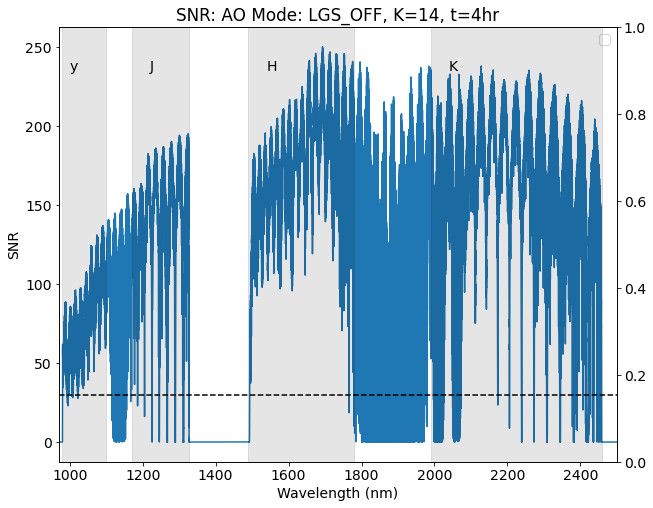

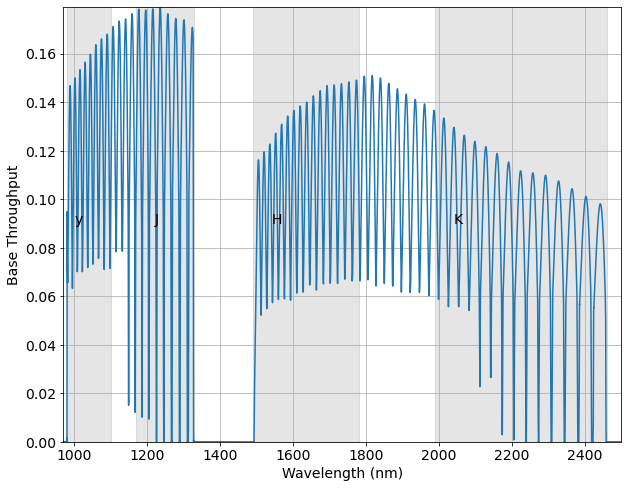

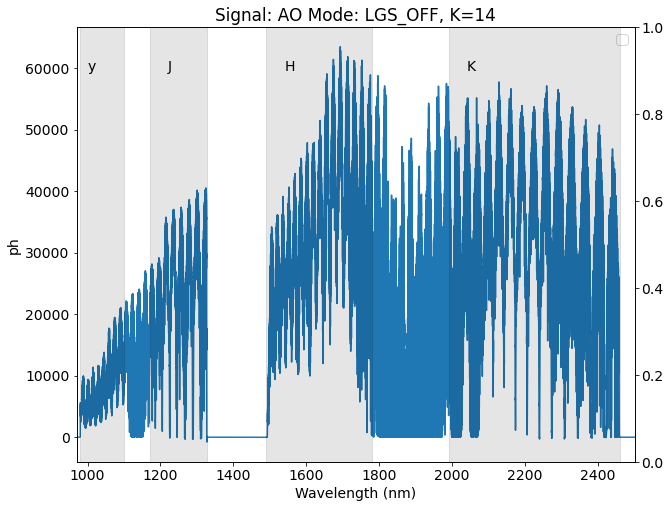

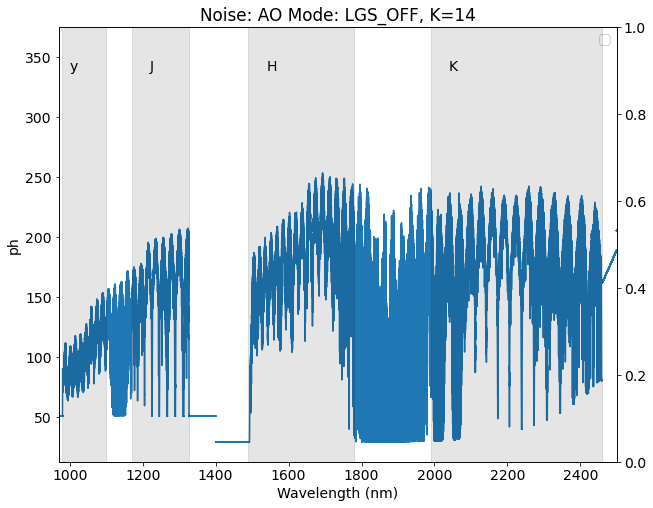

In [5]:
savepath = './'
plot_tools.plot_snr(so,snrtype=0,savepath=savepath) 
plot_tools.plot_base_throughput(so,savepath=savepath)
plot_tools.plot_photon(so,snrtype=0,savepath=savepath)
plot_tools.plot_noise(so,snrtype=0,savepath=savepath)
#plot_tools.plot_coupling(so,savepath=savepath) # these ones are weird
#plot_tools.plot_base_throughput(so,savepath=savepath)
#plot_tools.plot_tracking_bands(so,savepath=savepath)
#plot_tools.plot_background_spectra(so,savepath=savepath)

# Plotting the Spectrum, off-axis
There are several tools for plotting in plot_tools.py which we loaded earlier as plot_tools. Not all plot functions are currently working well and a lot require certain data paths to be fixed. 

Here is an example how to use some of the key ones that should work! For example, how to plot the signal spectrum, the background noise,the SNR spectrum, the sky noise, the instrument noise, etc. These functions take the so object, so it plots the parameters stored in so from the latest run.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


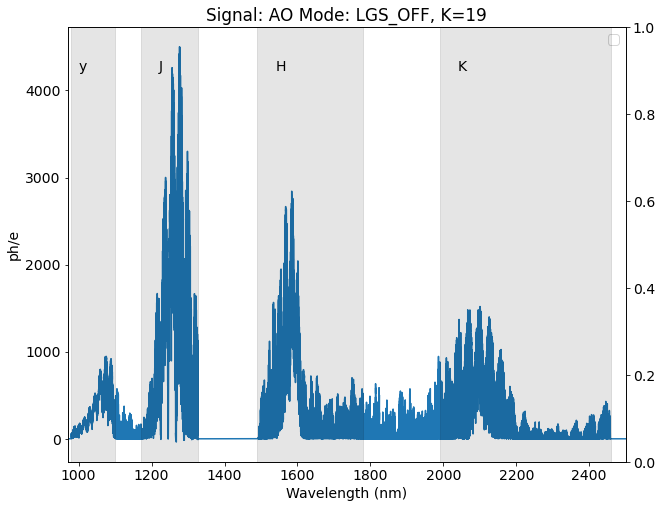

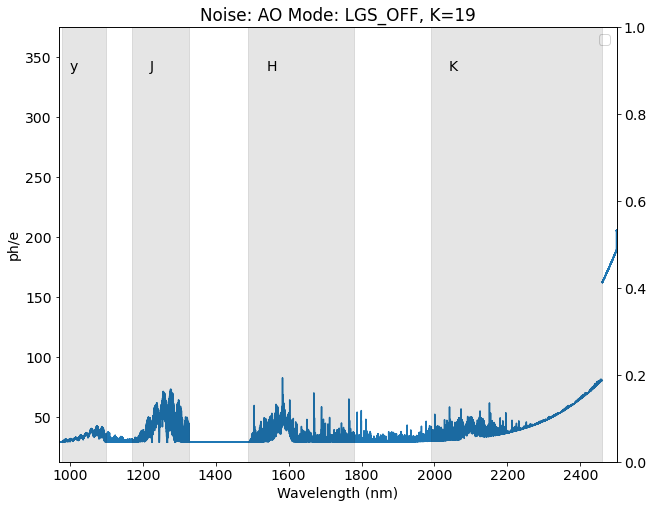

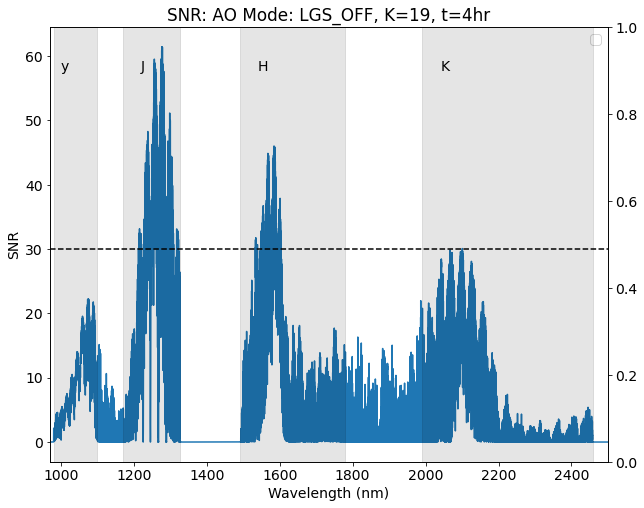

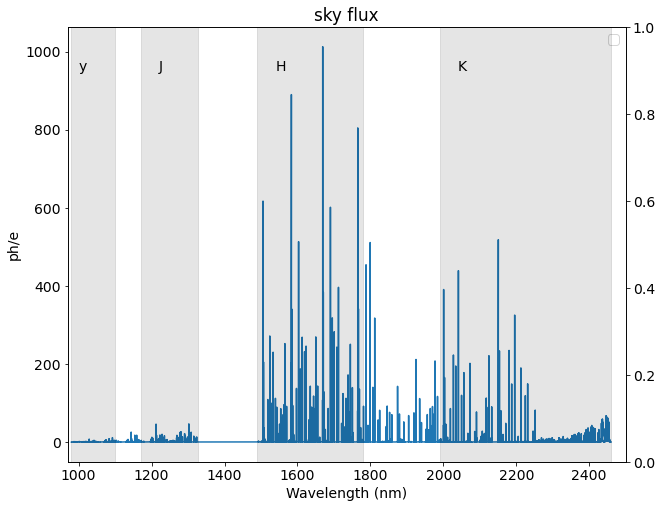

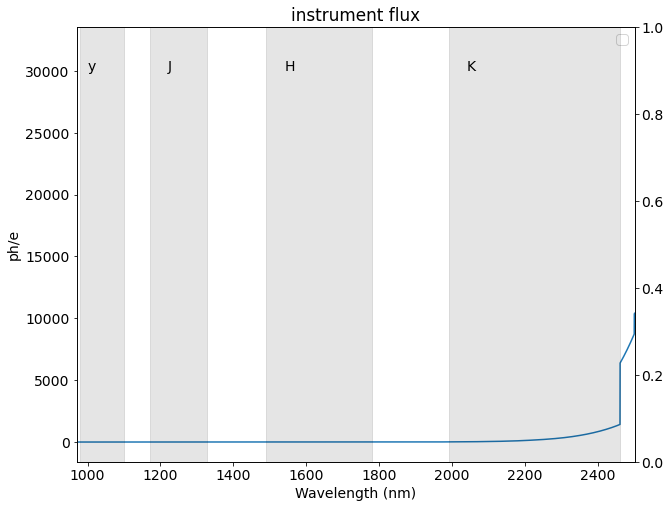

In [6]:
plot_tools.plot_DI_photon(so,savepath=savepath)
plot_tools.plot_DI_noise(so,savepath=savepath)
plot_tools.plot_DI_snr(so,savepath=savepath) #1
plot_tools.plot_sky_total(so,savepath=savepath)
plot_tools.plot_inst_total(so,savepath=savepath)

# Running a grid of parameters

Star Teff set to 3000
Star y band mag set to 14.0
HO WFE V mag is 19.457271721428924
Tip Tilt V mag is 19.457271721428924
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 5
HO WFE V mag is 10.457271661788546
Tip Tilt V mag is 10.457271661788546
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 632288979.5692225 e-
Tracking noise: 25145.389330005248 e-
Texp per frame set to 4.672584046352987
Nframes set to 3082


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 6
HO WFE V mag is 11.45727169904366
Tip Tilt V mag is 11.45727169904366
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 251718776.628461 e-
Tracking noise: 15865.698900987007 e-
Texp per frame set to 11.737000466122211
Nframes set to 1227


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 7
HO WFE V mag is 12.457271701540375
Tip Tilt V mag is 12.457271701540375
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 100211049.93874443 e-
Tracking noise: 10010.628098529272 e-
Texp per frame set to 29.482012217473986
Nframes set to 489


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 8
HO WFE V mag is 13.457271642141793
Tip Tilt V mag is 13.457271642141793
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 39894737.54930877 e-
Tracking noise: 6316.356745595369 e-
Texp per frame set to 74.05546646267257
Nframes set to 195


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 9
HO WFE V mag is 14.457271653669306
Tip Tilt V mag is 14.457271653669306
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 15882381.085729675 e-
Tracking noise: 3985.4743850699915 e-
Texp per frame set to 186.01892138669996
Nframes set to 78


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 10
HO WFE V mag is 15.457271678591361
Tip Tilt V mag is 15.457271678591361
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 6322889.795692223 e-
Tracking noise: 2514.8588000147392 e-
Texp per frame set to 467.2584046352988
Nframes set to 31


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 11
HO WFE V mag is 16.457271639489896
Tip Tilt V mag is 16.457271639489896
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 2517187.7662846097 e-
Tracking noise: 1587.0767954336552 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 12
HO WFE V mag is 17.45727164797154
Tip Tilt V mag is 17.45727164797154
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 1002110.4993874432 e-
Tracking noise: 1001.8660028700415 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 13
HO WFE V mag is 18.457271672289824
Tip Tilt V mag is 18.457271672289824
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 398947.3754930877 e-
Tracking noise: 632.9078636045207 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 14
HO WFE V mag is 19.457271721428924
Tip Tilt V mag is 19.457271721428924
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 158823.81085729654 e-
Tracking noise: 400.5606061217795 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star y band mag set to 15
HO WFE V mag is 20.45727166544691
Tip Tilt V mag is 20.45727166544691
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 63228.89795692226 e-
Tracking noise: 254.66426187487144 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


Star Teff set to 3000
Star J band mag set to 15
HO WFE V mag is 20.45727166544691
Tip Tilt V mag is 20.45727166544691
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 5
HO WFE V mag is 10.457271661788546
Tip Tilt V mag is 10.457271661788546
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 632288979.5692225 e-
Tracking noise: 25145.389330005248 e-
Texp per frame set to 4.672584046352987
Nframes set to 3082


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 6
HO WFE V mag is 11.45727169904366
Tip Tilt V mag is 11.45727169904366
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 251718776.628461 e-
Tracking noise: 15865.698900987007 e-
Texp per frame set to 11.737000466122211
Nframes set to 1227


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 7
HO WFE V mag is 12.457271701540375
Tip Tilt V mag is 12.457271701540375
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 100211049.93874443 e-
Tracking noise: 10010.628098529272 e-
Texp per frame set to 29.482012217473986
Nframes set to 489


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 8
HO WFE V mag is 13.457271642141793
Tip Tilt V mag is 13.457271642141793
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 39894737.54930877 e-
Tracking noise: 6316.356745595369 e-
Texp per frame set to 74.05546646267257
Nframes set to 195


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 9
HO WFE V mag is 14.457271653669306
Tip Tilt V mag is 14.457271653669306
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 15882381.085729675 e-
Tracking noise: 3985.4743850699915 e-
Texp per frame set to 186.01892138669996
Nframes set to 78


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 10
HO WFE V mag is 15.457271678591361
Tip Tilt V mag is 15.457271678591361
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 6322889.795692223 e-
Tracking noise: 2514.8588000147392 e-
Texp per frame set to 467.2584046352988
Nframes set to 31


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 11
HO WFE V mag is 16.457271639489896
Tip Tilt V mag is 16.457271639489896
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 2517187.7662846097 e-
Tracking noise: 1587.0767954336552 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 12
HO WFE V mag is 17.45727164797154
Tip Tilt V mag is 17.45727164797154
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 1002110.4993874432 e-
Tracking noise: 1001.8660028700415 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 13
HO WFE V mag is 18.457271672289824
Tip Tilt V mag is 18.457271672289824
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 398947.3754930877 e-
Tracking noise: 632.9078636045207 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 14
HO WFE V mag is 19.457271721428924
Tip Tilt V mag is 19.457271721428924
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 158823.81085729654 e-
Tracking noise: 400.5606061217795 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star J band mag set to 15
HO WFE V mag is 20.45727166544691
Tip Tilt V mag is 20.45727166544691
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 63228.89795692226 e-
Tracking noise: 254.66426187487144 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


Star Teff set to 3000
Star H band mag set to 15
HO WFE V mag is 20.45727166544691
Tip Tilt V mag is 20.45727166544691
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 5
HO WFE V mag is 10.457271661788546
Tip Tilt V mag is 10.457271661788546
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 632288979.5692225 e-
Tracking noise: 25145.389330005248 e-
Texp per frame set to 4.672584046352987
Nframes set to 3082


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 6
HO WFE V mag is 11.45727169904366
Tip Tilt V mag is 11.45727169904366
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 251718776.628461 e-
Tracking noise: 15865.698900987007 e-
Texp per frame set to 11.737000466122211
Nframes set to 1227


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 7
HO WFE V mag is 12.457271701540375
Tip Tilt V mag is 12.457271701540375
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 100211049.93874443 e-
Tracking noise: 10010.628098529272 e-
Texp per frame set to 29.482012217473986
Nframes set to 489


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 8
HO WFE V mag is 13.457271642141793
Tip Tilt V mag is 13.457271642141793
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 39894737.54930877 e-
Tracking noise: 6316.356745595369 e-
Texp per frame set to 74.05546646267257
Nframes set to 195


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 9
HO WFE V mag is 14.457271653669306
Tip Tilt V mag is 14.457271653669306
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 15882381.085729675 e-
Tracking noise: 3985.4743850699915 e-
Texp per frame set to 186.01892138669996
Nframes set to 78


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 10
HO WFE V mag is 15.457271678591361
Tip Tilt V mag is 15.457271678591361
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 6322889.795692223 e-
Tracking noise: 2514.8588000147392 e-
Texp per frame set to 467.2584046352988
Nframes set to 31


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 11
HO WFE V mag is 16.457271639489896
Tip Tilt V mag is 16.457271639489896
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 2517187.7662846097 e-
Tracking noise: 1587.0767954336552 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 12
HO WFE V mag is 17.45727164797154
Tip Tilt V mag is 17.45727164797154
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 1002110.4993874432 e-
Tracking noise: 1001.8660028700415 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 13
HO WFE V mag is 18.457271672289824
Tip Tilt V mag is 18.457271672289824
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 398947.3754930877 e-
Tracking noise: 632.9078636045207 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 14
HO WFE V mag is 19.457271721428924
Tip Tilt V mag is 19.457271721428924
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 158823.81085729654 e-
Tracking noise: 400.5606061217795 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star H band mag set to 15
HO WFE V mag is 20.45727166544691
Tip Tilt V mag is 20.45727166544691
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 63228.89795692226 e-
Tracking noise: 254.66426187487144 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


Star Teff set to 3000
Star K band mag set to 15
HO WFE V mag is 20.45727166544691
Tip Tilt V mag is 20.45727166544691
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 5
HO WFE V mag is 10.457271661788546
Tip Tilt V mag is 10.457271661788546
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 632288979.5692225 e-
Tracking noise: 25145.389330005248 e-
Texp per frame set to 4.672584046352987
Nframes set to 3082


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 6
HO WFE V mag is 11.45727169904366
Tip Tilt V mag is 11.45727169904366
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 251718776.628461 e-
Tracking noise: 15865.698900987007 e-
Texp per frame set to 11.737000466122211
Nframes set to 1227


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 7
HO WFE V mag is 12.457271701540375
Tip Tilt V mag is 12.457271701540375
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 100211049.93874443 e-
Tracking noise: 10010.628098529272 e-
Texp per frame set to 29.482012217473986
Nframes set to 489


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 8
HO WFE V mag is 13.457271642141793
Tip Tilt V mag is 13.457271642141793
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 39894737.54930877 e-
Tracking noise: 6316.356745595369 e-
Texp per frame set to 74.05546646267257
Nframes set to 195


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 9
HO WFE V mag is 14.457271653669306
Tip Tilt V mag is 14.457271653669306
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 15882381.085729675 e-
Tracking noise: 3985.4743850699915 e-
Texp per frame set to 186.01892138669996
Nframes set to 78


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 10
HO WFE V mag is 15.457271678591361
Tip Tilt V mag is 15.457271678591361
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 6322889.795692223 e-
Tracking noise: 2514.8588000147392 e-
Texp per frame set to 467.2584046352988
Nframes set to 31


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 11
HO WFE V mag is 16.457271639489896
Tip Tilt V mag is 16.457271639489896
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 2517187.7662846097 e-
Tracking noise: 1587.0767954336552 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 12
HO WFE V mag is 17.45727164797154
Tip Tilt V mag is 17.45727164797154
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 1002110.4993874432 e-
Tracking noise: 1001.8660028700415 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 13
HO WFE V mag is 18.457271672289824
Tip Tilt V mag is 18.457271672289824
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 398947.3754930877 e-
Tracking noise: 632.9078636045207 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 14
HO WFE V mag is 19.457271721428924
Tip Tilt V mag is 19.457271721428924
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 158823.81085729654 e-
Tracking noise: 400.5606061217795 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


-----Reloading Stellar Magnitude-----
Star Teff set to 3000
Star K band mag set to 15
HO WFE V mag is 20.45727166544691
Tip Tilt V mag is 20.45727166544691
AO mode: LGS_ON
HO WFE is 204.0
tt dynamic is 2.09
Tracking FWHM=3.6743208654820827pix
Tracking photons: 63228.89795692226 e-
Tracking noise: 254.66426187487144 e-
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


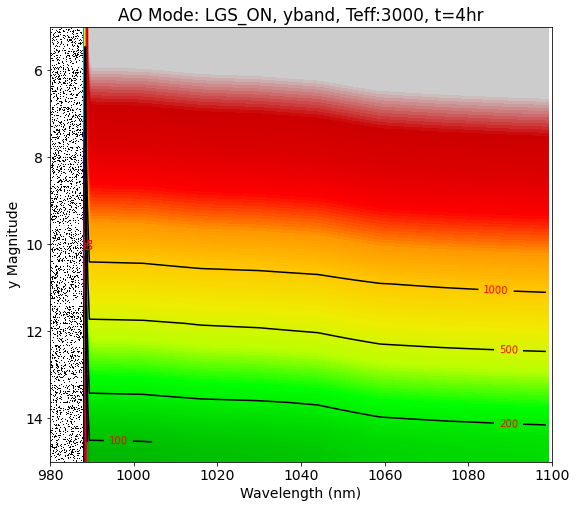

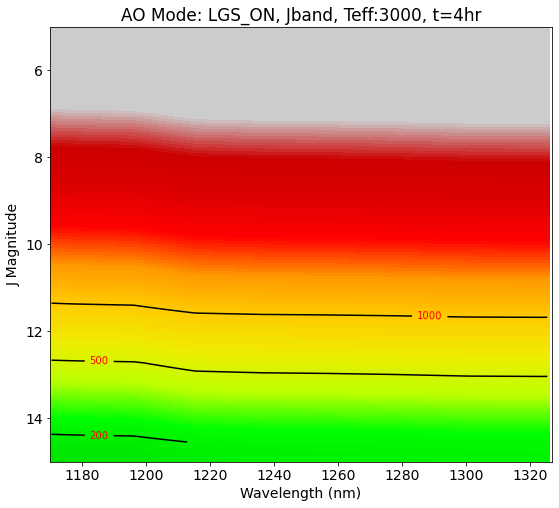

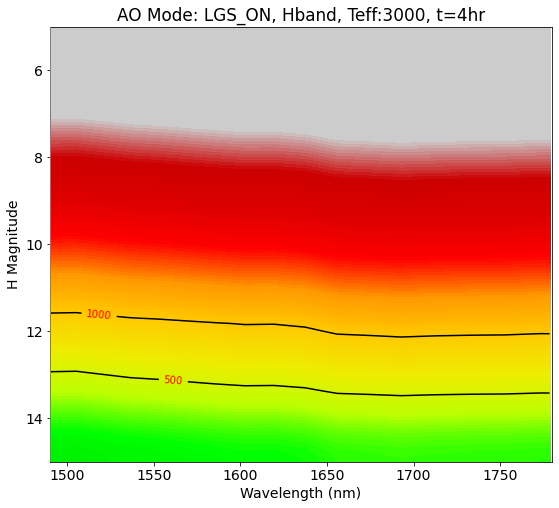

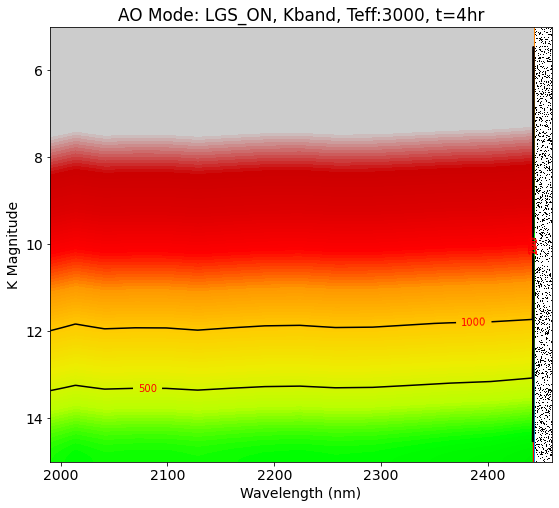

In [7]:
def run_snr_v_mag(so,teff='default',ao_mode='default'):
    """
    code to step through magnitudes
    """
    if teff!='default':  so.stel.teff = teff
    if ao_mode!='default':  so.ao.mode = ao_mode # load new ao mode

    cload.set_teff_mag(so,teff,so.stel.mag,star_only=False)
    mag_arr= np.arange(5,16)
    snr_arr = []
    s_arr   = []
    n_arr   = []
    c_arr   = []
    snr_reselement= []

    for mag in mag_arr:
        cload.set_mag(so,mag) 
        snr_arr.append(so.obs.snr)
        s_arr.append(so.obs.s_frame)
        snr_reselement.append(so.obs.snr_reselement) # plot snr per res element
        n_arr.append(so.obs.noise_frame)
        c_arr.append(so.inst.coupling)

    return mag_arr,snr_arr,s_arr,n_arr,c_arr,snr_reselement

def plot_snr_mag_peaks_2d(so, mag_arr,v,snr_arr,xextent=[980,2460],mode='max'):
    """
    """
    def fmt(x):
        return str(int(x))

    snr_arr_order= []
    for i,mag in enumerate(mag_arr):
        cen_lam, snr_peaks,snr_means = obs_tools.get_order_value(so,v,snr_arr[i])
        if mode=='max':
            #ax.plot(cen_lam,snr_peaks,label='m=%s'%mag)
            snr_arr_order.append(snr_peaks)
        elif mode=='mean':
            #ax.plot(cen_lam,snr_means,label='m=%s'%mag)
            snr_arr_order.append(snr_means)

    snr_arr_order = np.array(snr_arr_order)

    # resample onto regular grid for imshow
    #xs = np.arange(np.min(cen_lam),np.max(cen_lam))
    xs = np.arange(np.min(xextent), np.max(xextent))
    snr_arr_order_regular = np.zeros((len(mag_arr),len(xs)))
    for i,mag in enumerate(mag_arr):
        tmp = interpolate.interp1d(cen_lam, snr_arr_order[i],kind='linear',bounds_error=False,fill_value=0)
        snr_arr_order_regular[i,:] = tmp(xs)

    extent = (np.min(xs),np.max(xs),np.min(mag_arr),np.max(mag_arr))

    

    fig, ax = plt.subplots(1,1, figsize=(9,8))	
    norm = LogNorm(vmin=1, vmax=10000)

    ax.imshow(snr_arr_order_regular, aspect='auto', origin='lower',
              interpolation='quadric', cmap='nipy_spectral', extent=extent, norm=norm)
#    ax.imshow(snr_arr_order_regular,aspect='auto',origin='lower',\
#                interpolation='quadric',cmap='nipy_spectral',\
#                extent=extent,vmax=10000,vmin=1,norm=LogNorm())
    cs = ax.contour(snr_arr_order_regular, levels=[30,50,100,200,500,1000] ,\
                colors=['r','k','k','k','k','k'],origin='lower',\
                extent=extent)
    ax.invert_yaxis()
    ax.clabel(cs, cs.levels, inline=True,fmt=fmt,fontsize=10,\
        colors=['r','r','r','r'],zorder=101)
    #plt.xticks(list(cen_lam))
    blackout = [1327,1490]
    plt.fill_between(blackout,np.min(mag_arr),np.max(mag_arr),facecolor='k',\
            hatch='X',edgecolor='gray',zorder=100)
    try:
        c30   = cs.collections[0].get_paths()[1].vertices # extract 30 snr curve
        c30_2 = cs.collections[0].get_paths()[0].vertices # extract 30 snr curve
        plt.fill_between(c30[:,0],np.max(mag_arr),c30[:,1],hatch='/',fc='k',edgecolor='r')
        plt.fill_between(c30_2[:,0],np.max(mag_arr),c30_2[:,1],hatch='/',fc='k',edgecolor='r')
    except IndexError:
        pass

    ax.set_ylabel('%s Magnitude'%so.filt.band)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_xlim(xextent)
    ax.set_title('AO Mode: %s, %sband, Teff:%s, t=4hr'%(so.ao.mode,so.filt.band,so.stel.teff))
    figname = 'snr2d_%s_band_%s_teff_%s_texp_%ss.png' %(so.ao.mode,so.filt.band,so.stel.teff,so.obs.texp)
    # duplicate axis to plot filter response
    plt.savefig('./' + figname)



datestr  = date.today().strftime("%Y%m%d")#'20230406' #date.today().strftime("%Y%m%d")		
savepath = './output/snr_out/%s/' %datestr
if not os.path.isdir(savepath): os.makedirs(savepath)
for i in np.arange(4):
    so.filt.band   = ['y','J','H','K'][i]
    so.filt.family = ['cfht','2mass','2mass','2mass'][i]
    xextent = [so.inst.y,so.inst.J,so.inst.H,so.inst.K][i]

    # mag step
    teff    = 3000
    ao_mode = 'LGS_ON'
    mag_arr,snr_arr,s_arr,n_arr,c_arr,snr_reselement = run_snr_v_mag(so,teff=teff,ao_mode=ao_mode)
    #np.save(savepath + 'snr_arr_mag_teff_%s_band_%s_aomode_%s'%(so.stel.teff,so.filt.band,ao_mode),snr_arr,ao_mode)		
    plot_snr_mag_peaks_2d(so, mag_arr,so.obs.v_resamp,snr_reselement,xextent=xextent,mode='max')
    #plt.savefig(savepath + 'snr_arr_mag_teff_%s_band_%s_aomode_%s.png'%(so.stel.teff,so.filt.band,ao_mode))
    #plot_snr_mag_peaks(so, mag_arr,so.obs.v_resamp,snr_reselement,mode='max')



## HISPEC

In [8]:
configfile = '/Users/huihaoz/specsim/examples/hispec.cfg' # define our config file name and path
so    = load_object(configfile)     # Load the contents of the config file into the so "storage object"
cload = fill_data(so)               # Initiate the fill_data class which runs an observation and stores the results in so

------FILLING OBJECT--------
Planet Teff set to 700.0
Planet K band mag set to 19.0
Star Teff set to 2800.0
Star K band mag set to 14.0
HO WFE J mag is 14.98574280240964
Tip Tilt J mag is 14.98574280240964
AO mode: LGS_100J_45
HO WFE is 207.0
tt dynamic is 15.911150280684339
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


Tracking FWHM=4.843209329675604pix
Tracking photons: 16622.914547886732 e-
Tracking noise: 139.47609251519944 e-
dynamic instrument contrast ready
Texp per frame set to 900.0
Nframes set to 16
direct imaging ready


/Users/huihaoz/specsim/utils/noise_tools.py:252: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:256: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)


# Plotting the Spectrum, on-axis

There are several tools for plotting in plot_tools.py which we loaded earlier as plot_tools. Not all plot functions are currently working well and a lot require certain data paths to be fixed. 

Here is an example how to use some of the key ones that should work! For example, how to plot the SNR spectrum, the base throughput, the background noise,the signal spectrum, etc. These functions take the so object, so it plots the parameters stored in so from the latest run.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


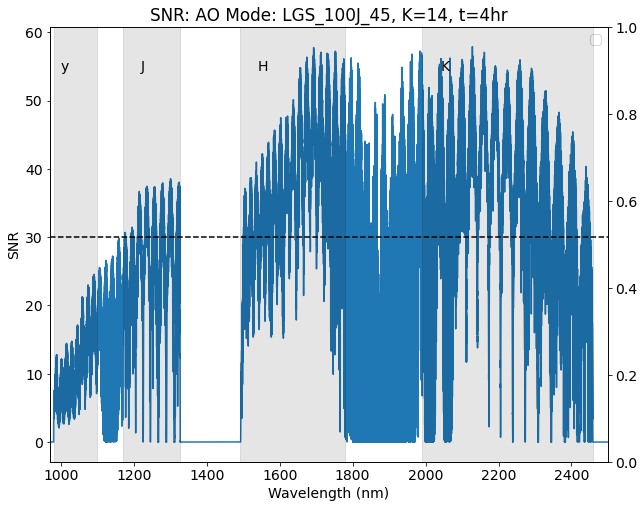

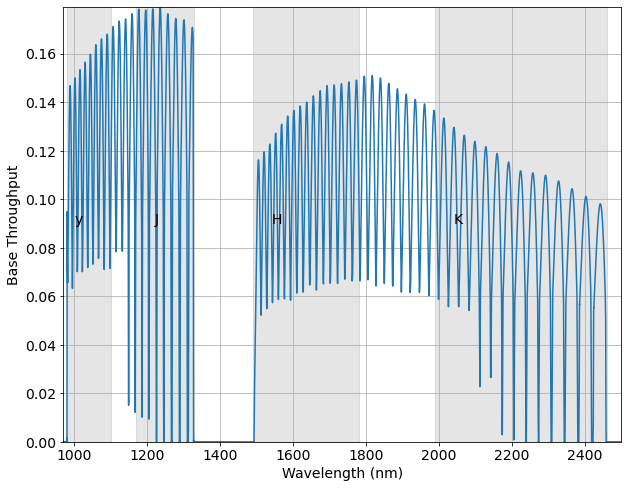

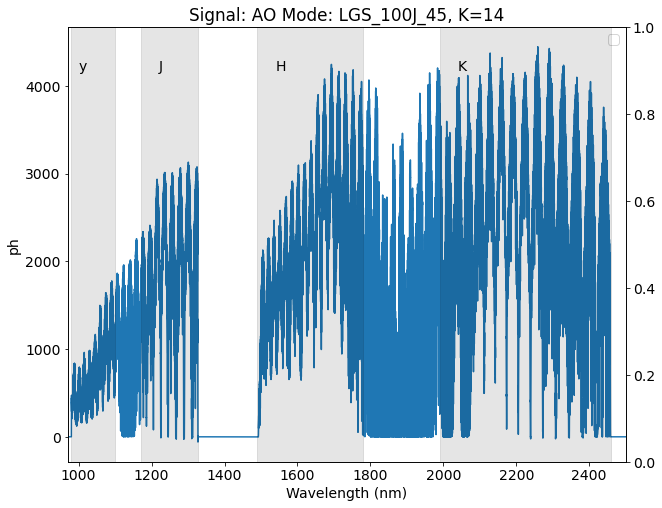

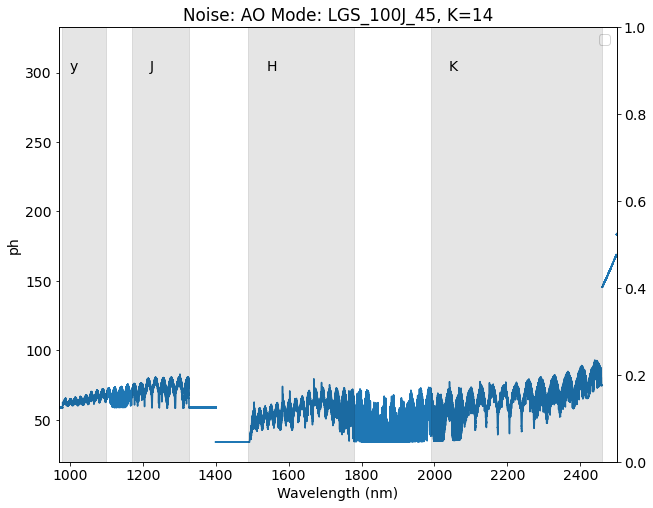

In [9]:
savepath = './'

plot_tools.plot_snr(so,snrtype=0,savepath=savepath) 

plot_tools.plot_base_throughput(so,savepath=savepath)

plot_tools.plot_photon(so,snrtype=0,savepath=savepath)

plot_tools.plot_noise(so,snrtype=0,savepath=savepath)

# Plotting the Spectrum, off-axis

There are several tools for plotting in plot_tools.py which we loaded earlier as plot_tools. Not all plot functions are currently working well and a lot require certain data paths to be fixed. 

Here is an example how to use some of the key ones that should work! For example, how to plot the signal spectrum, the background noise,the SNR spectrum, the sky noise, the instrument noise, etc. These functions take the so object, so it plots the parameters stored in so from the latest run.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


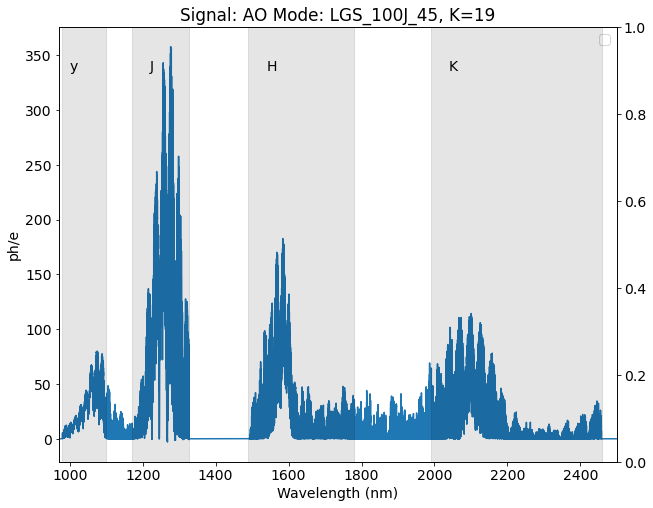

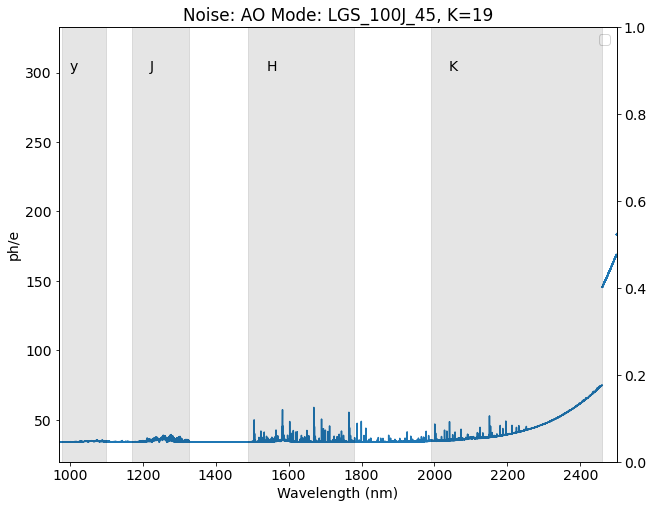

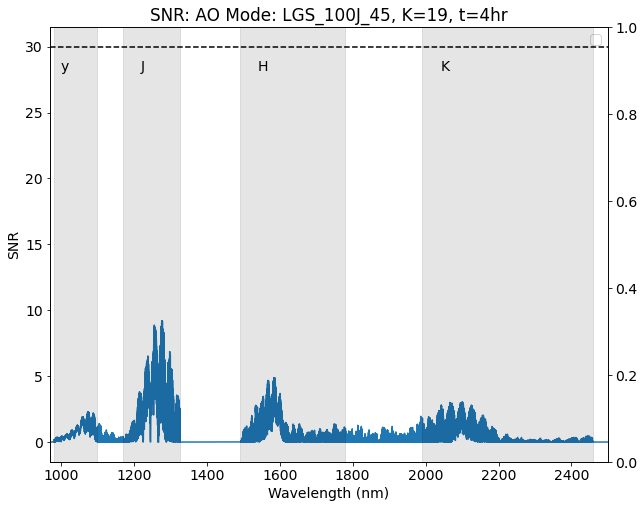

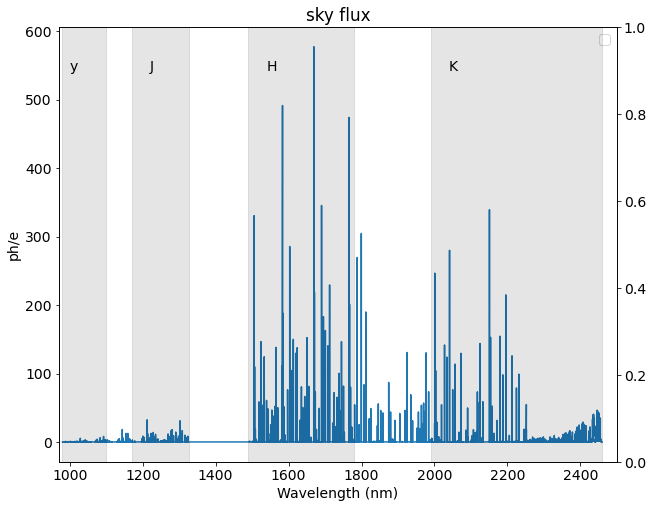

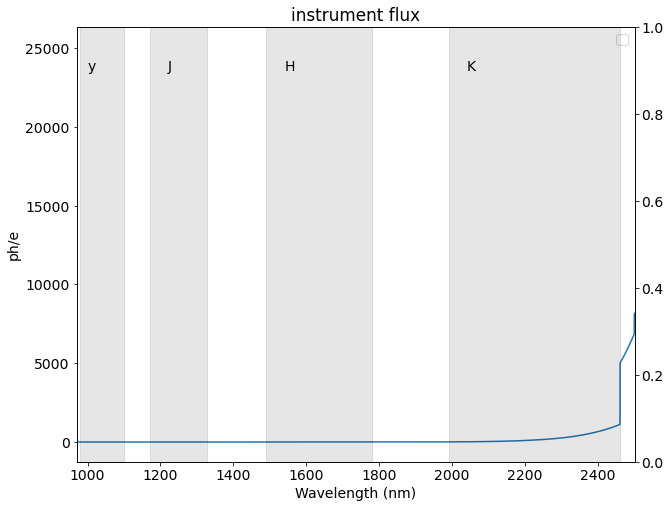

In [10]:
plot_tools.plot_DI_photon(so,savepath=savepath)

plot_tools.plot_DI_noise(so,savepath=savepath)

plot_tools.plot_DI_snr(so,savepath=savepath) #1

plot_tools.plot_sky_total(so,savepath=savepath)

plot_tools.plot_inst_total(so,savepath=savepath)

# Future Implementation List

- add a function that prints key parameters defined in "so" - perhaps be able to print a summary for each item like telluric, stellar, etc. And also a general one

- make plotting scripts work, cut out ones that dont work or work on saved files not included in the utilities (e.g. only save plot scripts that plot things from so object)

- make things that point to a file path work from the config

- implement variable resolution

- implement testing functions to test things are working properly - one good test is to check the validity of magnitude conversions, like the colors of the given star can be checked

- comment objects.py and add all new variables to init